In [ ]:
import os, time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend as K
from tensorflow.keras.utils import image_dataset_from_directory
from IPython import display
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import cv2

In [33]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [34]:
img_height, img_width = 256, 256
batch_size = 128
DATA_DIR = 'D:/UFU/cartoonset10k'

In [35]:
train_ds = image_dataset_from_directory(
  DATA_DIR,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=None)

Found 10000 files belonging to 1 classes.


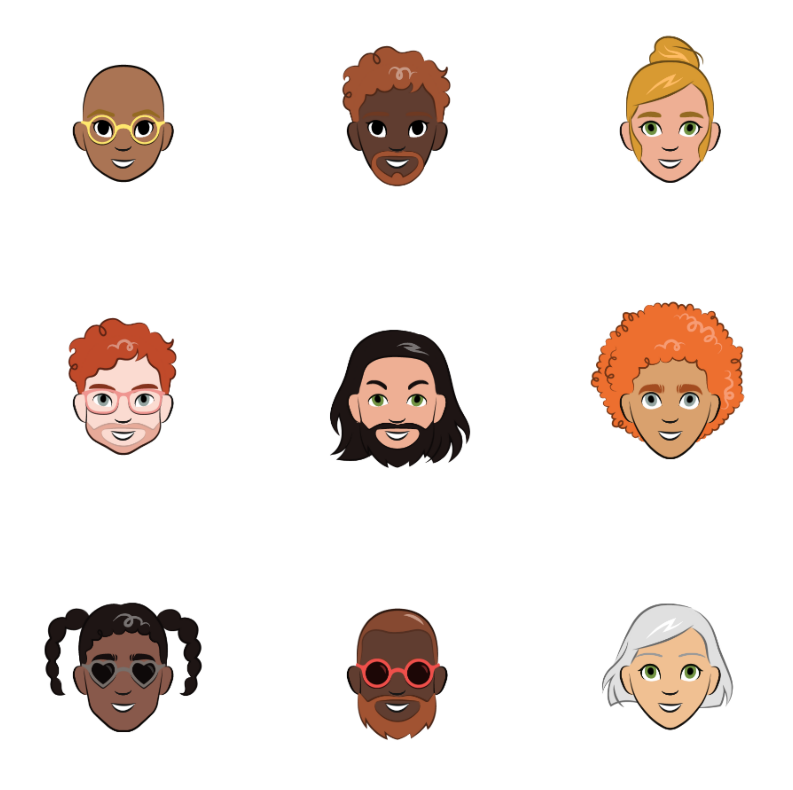

In [36]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [37]:
normalization_layer = layers.Rescaling(scale= 1./255)

In [38]:
normalized_ds = train_ds.map(lambda x: normalization_layer(x))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [39]:
print(np.min(first_image), np.max(first_image)) 

0.04705883 1.0


In [40]:
input_encoder = (256, 256, 3)
input_decoder = (200,)

In [41]:
def sampling_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    return mean + K.exp(log_var / 2) * epsilon

In [ ]:
def encoder(input_encoder):
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    # Block-1
    x = layers.Conv2D(32, kernel_size=3, strides= 2, 
                      padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    # Block-2
    x = layers.Conv2D(64, kernel_size=3, strides= 2, 
                      padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    # Block-3
    x = layers.Conv2D(64, 3, 2, padding='same', 
                      name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
    # Block-4
    x = layers.Conv2D(64, 3, 2, padding='same', 
                      name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
    # Block-5
    x = layers.Conv2D(64, 3, 2, padding='same', 
                      name='conv_5')(x)
    x = layers.BatchNormalization(name='bn_5')(x)
    x = layers.LeakyReLU(name='lrelu_5')(x)
    # Final Block
    flatten = layers.Flatten()(x)
    mean = layers.Dense(200, name='mean')(flatten)
    log_var = layers.Dense(200, name='log_var')(flatten)
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    return model

In [43]:
enc = encoder(input_encoder)

In [44]:
# enc.save('vae-cartoon-enc.h5')

In [45]:
enc.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 128, 128, 32)         896       ['input_layer[0][0]']         
                                                                                                  
 bn_1 (BatchNormalization)   (None, 128, 128, 32)         128       ['conv_1[0][0]']              
                                                                                                  
 lrelu_1 (LeakyReLU)         (None, 128, 128, 32)         0         ['bn_1[0][0]']                
                                                                                            

In [46]:
input_1 = (200,)
input_2 = (200,)

In [ ]:
def sampling(input_1,input_2):
    mean = keras.Input(shape=input_1, name='input_layer1')
    log_var = keras.Input(shape=input_2, name='input_layer2')
    out = layers.Lambda(sampling_model, name='encoder_output')([mean, log_var])
    enc_2 = tf.keras.Model([mean,log_var], out,  name="Encoder_2")
    return enc_2

In [48]:
final = sampling(input_1,input_2)

In [49]:
# final.save('sampling-cartoon.h5')

In [ ]:
def decoder(input_decoder):
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(4096, name='dense_1')(inputs)
    x = layers.Reshape((8,8,64), name='Reshape')(x)
    # Block-1
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same',
                                name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same',
                                name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    # Block-3
    x = layers.Conv2DTranspose(64, 3, 2, padding='same', 
                               name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
    # Block-4
    x = layers.Conv2DTranspose(32, 3, 2, padding='same',
                                name='conv_transpose_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
    # Block-5
    outputs = layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', 
                                     name='conv_transpose_5')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [51]:
dec = decoder(input_decoder)

In [52]:
# dec.save('vae-cartoon-dec.h5')

In [53]:
dec.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200)]             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              823296    
                                                                 
 Reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv_transpose_1 (Conv2DTr  (None, 16, 16, 64)        36928     
 anspose)                                                        
                                                                 
 bn_1 (BatchNormalization)   (None, 16, 16, 64)        256       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 16, 16, 64)        0         
                                                           

In [54]:
#model.layers[1].get_weights()

In [55]:
#model.save('autoencoder.h5')

In [56]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)

In [57]:
def mse_loss(y_true, y_pred):
    return 1000.0 * K.mean(K.square(y_true - y_pred), axis=[1,2,3])

def kl_loss(mean, log_var):
    return -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis=1)  

def vae_loss(y_true, y_pred, mean, log_var):
    return mse_loss(y_true, y_pred) + kl_loss(mean, log_var)  


In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
        mean, log_var = enc(images, training=True)
        latent = final([mean, log_var])
        generated_images = dec(latent, training=True)
        loss_vec = vae_loss(images, generated_images, mean, log_var) 
        loss = tf.reduce_mean(loss_vec) 
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss

In [59]:
os.makedirs('tf_vae/cartoon/training_weights', exist_ok=True)
os.makedirs('tf_vae/cartoon/images', exist_ok=True)

In [60]:
def generate_and_save_images(epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    mean, var = enc(test_input, training=False)
    latent = final([mean, var])
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        pred = predictions[i, :, :, :] * 255
        pred = np.array(pred)  
        pred = pred.astype(np.uint8)
        #cv2.imwrite('tf_ae/images/image'+ str(i)+'.png',pred)
        
        plt.imshow(pred)
        plt.axis('off')

    plt.savefig('tf_vae/cartoon/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

In [61]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss_ = []
        for image_batch in dataset:
            i += 1
            loss = train_step(image_batch)
            #loss_.append(loss)

        #print("Loss",np.mean(loss_))    
        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_and_save_images(epoch + 1, seed)
        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)
        enc.save_weights(f'tf_vae/cartoon/training_weights/enc_{epoch+1}.h5')
        dec.save_weights(f'tf_vae/cartoon/training_weights/dec_{epoch+1}.h5')
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(epoch + 1, seed)

(16, 256, 256, 3)


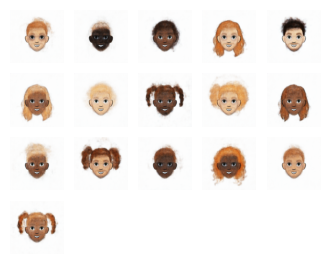

In [62]:
train(normalized_ds, 30)

In [63]:
# enc.load_weights('tf_vae/cartoon/training_weights/enc_29.h5')

In [64]:
# dec.load_weights('tf_vae/cartoon/training_weights/dec_29.h5')

In [65]:
embeddings = None
mean = None
var = None
for i in normalized_ds:
    m,v = enc.predict(i)
    embed = final.predict([m,v])
    #embed = dec.predict(latent)
    if embeddings is None:
        embeddings = embed
        mean = m
        var = v
    else:
        embeddings = np.concatenate((embeddings, embed))
        mean = np.concatenate((mean, m))
        var = np.concatenate((var, v))
    if embeddings.shape[0] > 5000:
        break

4/4 [==============================] - 0s 802us/step


In [66]:
embeddings.shape

(5120, 200)

## Latent Space Projection with t-SNE of VAE Trained on Cartoon Set

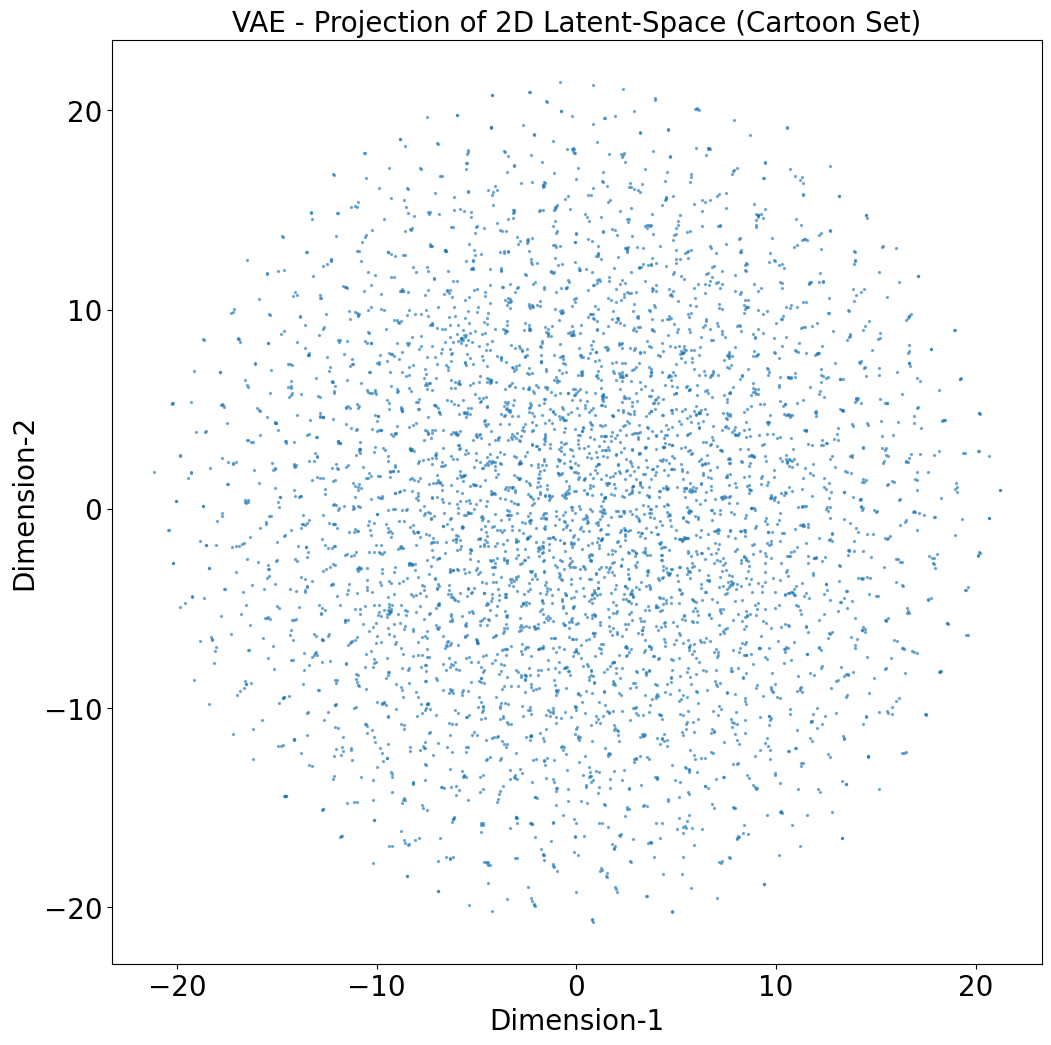

In [67]:
n_to_show = 5000
grid_size = 15
figsize = 12

tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=0)
X_tsne = tsne.fit_transform(embeddings)
min_x = min(X_tsne[:, 0])
max_x = max(X_tsne[:, 0])
min_y = min(X_tsne[:, 1])
max_y = max(X_tsne[:, 1])


plt.figure(figsize=(figsize, figsize))
plt.scatter(X_tsne[:, 0] , X_tsne[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("VAE - Projection of 2D Latent-Space (Cartoon Set)", size=20)
plt.show()

In [68]:
reconstruction = None
lat_space = None
for i in normalized_ds:
    m,v = enc.predict(i)
    latent = final([m,v])
    out = dec.predict(latent)
    if reconstruction is None:
        reconstruction = out
        lat_space = latent
    else:
        reconstruction = np.concatenate((reconstruction, out))
        lat_space = np.concatenate((lat_space, latent))
    if reconstruction.shape[0] > 5000:
        break

4/4 [==============================] - 0s 75ms/step


In [69]:
reconstruction.shape

(5120, 256, 256, 3)

## Reconstructing Test Images

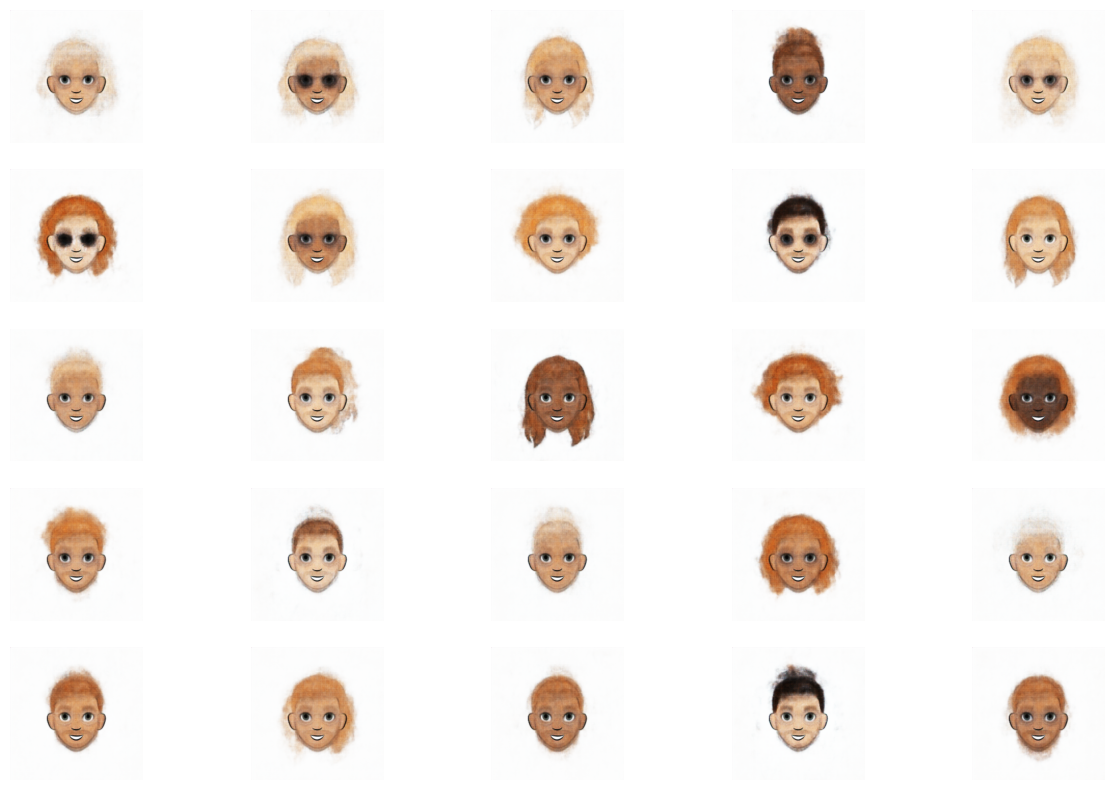

In [70]:
figsize = 15


fig = plt.figure(figsize=(figsize, 10))

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruction[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    
    ax.imshow(pred)

## Reconstructing Cartoon Images from a Latent-Vector Sampled with Normal Distribution

1/1 [==============================] - 2s 2s/step


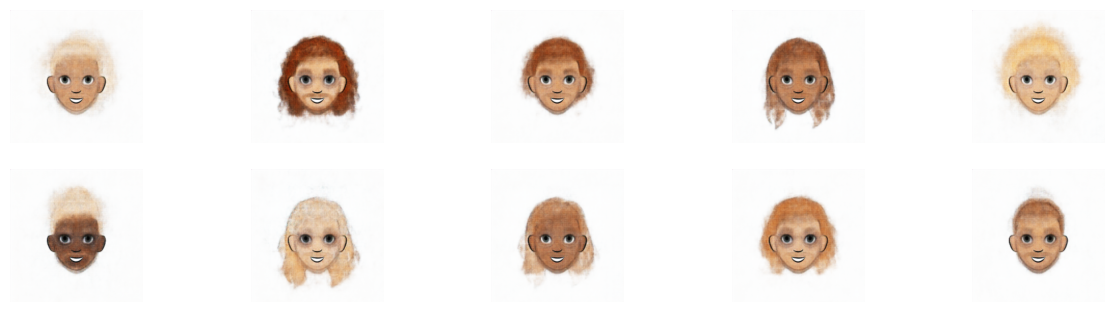

In [71]:
figsize = 15


x = np.random.normal(size = (10,200))
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

## Reconstructing Cartoon Images with Latent-Vector Sampled Uniformly

(10, 200)
1/1 [==============================] - 0s 70ms/step


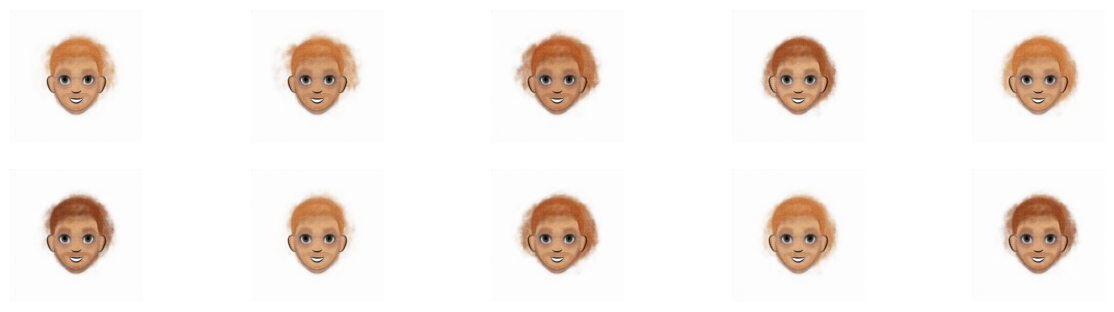

In [72]:
figsize = 15


min_x = lat_space.min(axis=0)
max_x = lat_space.max(axis=0)
x = np.random.uniform(size = (10,200))
x = x * (max_x - (np.abs(min_x))) 
print(x.shape)
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)